# ASSIGNMENT 4                                                McGill COMP451 
Student name (ID) 260907163

- Did you discuss your solution with classmates? (yes/no) no    
- If yes, please list their names here: 
- Did you use LLMs such as chatGPT in finding a solution to any of the problems below? (yes/no) yes


In [3]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt 
from IPython.core.debugger import set_trace #this is used for debugging
np.random.seed(1234) 

## Problem 1. kNN (6 pts)

### 1a) Weighted kNN Classification (4pts)
In this assignment we want to implement a variation of kNN where we weight the classification vote of each point by the inverse of their distance to the test point. Fill in the code below to complete the implementation. 

In [1]:
import numpy as np

# Define the metrics for measuring similarity
euclidean = lambda x1, x2: np.sqrt(np.sum((x1 - x2)**2, axis=-1))
manhattan = lambda x1, x2: np.sum(np.abs(x1 - x2), axis=-1)

class WeightedKNN:
    def __init__(self, K=3, dist_fn=euclidean):
        self.dist_fn = dist_fn
        self.K = K  # Number of neighbors
        return
    
    def fit(self, x, y):
        self.x = x  # Store the training data
        self.y = y
        self.C = np.max(y) + 1  # Number of classes
        return self
    
    def predict(self, x_test):
        n_test = x_test.shape[0]
        distances = self.dist_fn(self.x[None, :, :], x_test[:, None, :])  # n_test x n_train
        y_prob = np.zeros((n_test, self.C))  # Probabilities for each class

        for i in range(n_test):
            # Sort distances and take the indices of the K closest points
            inds = np.argsort(distances[i])[:self.K]

            for k in inds:
                label = self.y[k]
                # Avoid division by zero if distance is 0
                weight = 1 / (distances[i, k] if distances[i, k] != 0 else 1e-5)
                y_prob[i, label] += weight

        # Normalize the probabilities
        y_prob = y_prob / np.sum(y_prob, axis=1, keepdims=True)

        return y_prob



### 1.b.) classifying faces (2pts)
Next we use this method to classify face images. We use the *Olivetti face dataset*. The dataset contains 400 images of 40 people -- that is we have 10 images for each person. Each image is `64x64` and in black and white. Let us visualize some examples from the dataset.

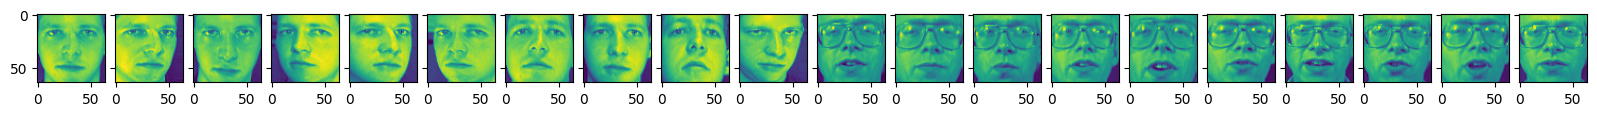

In [16]:
from sklearn import datasets 
from mpl_toolkits.axes_grid1 import ImageGrid                         #To plot the images in grid and we have seen it befoer 

x,y = datasets.fetch_olivetti_faces(return_X_y=True)
def plot_images(data):
    num_plots = data.shape[0]
    fig = plt.figure(figsize=(num_plots, 10.*num_plots))
    grid = ImageGrid(fig, 111, nrows_ncols=(1, num_plots), axes_pad=0.1)
    for i in range(num_plots):
        grid[i].imshow(data[i].reshape((64,64)))
    plt.show()
plot_images(x[:20]) 

Below, we plot the 10 nearest neighbours to the first face image above. We see that a few of closest neighbours can be used to classify the face image.

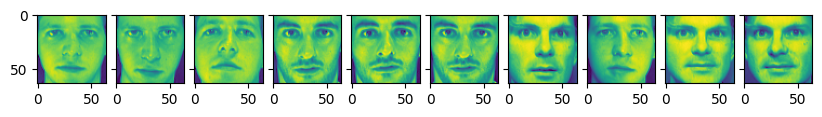

In [17]:
_, neighbours = WeightedKNN(K=10).fit(x,y).predict(x[[0]])
plot_images(x[neighbours[0]])

Shuffle the dataset and use 20% of the data for validation. Report the best hyper-parameter `K` using the validation set. You can use helper functions from `scikit-learn`.

In [3]:
# YOUR CODE HERE >>>>>>>>>>>>>>>>>>>>>>>
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import datasets

# Load Olivetti faces dataset
x, y = datasets.fetch_olivetti_faces(return_X_y=True)

# Shuffle and split the dataset into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42)

def evaluate_model(k, x_train, y_train, x_val, y_val):
    # Initialize model with given k
    model = WeightedKNN(K=k).fit(x_train, y_train)

    # Make predictions
    predictions = model.predict(x_val)

    # Evaluate accuracy
    accuracy = np.mean(np.argmax(predictions, axis=1) == y_val)
    return accuracy

# Try different values of K
k_values = range(1, 20)
accuracies = []
for k in k_values:
    acc = evaluate_model(k, x_train, y_train, x_val, y_val)
    accuracies.append(acc)

# Find the best K
best_k = k_values[np.argmax(accuracies)]
print(f"The best K is {best_k} with an accuracy of {max(accuracies)}")



The best K is 1 with an accuracy of 0.9125


## Problem 2. Principal Component Analysis (7 pts)

### 2.a.) Eigenfaces (2)
For this assignment, we will find the principle compomponents of the face dataset, these are the eigenvectors of the covariance matrix, and sometimes called *eigenfaces* for face datasets.
Perform PCA and plot the first 20 eigenfaces. To do PCA you can either use the method discussed in the class (i.e., find the eigenvectors of the covariance matrix), or use the method explained in bonus slides, which uses Singular Value Decomposition (SVD), and is more stable. 

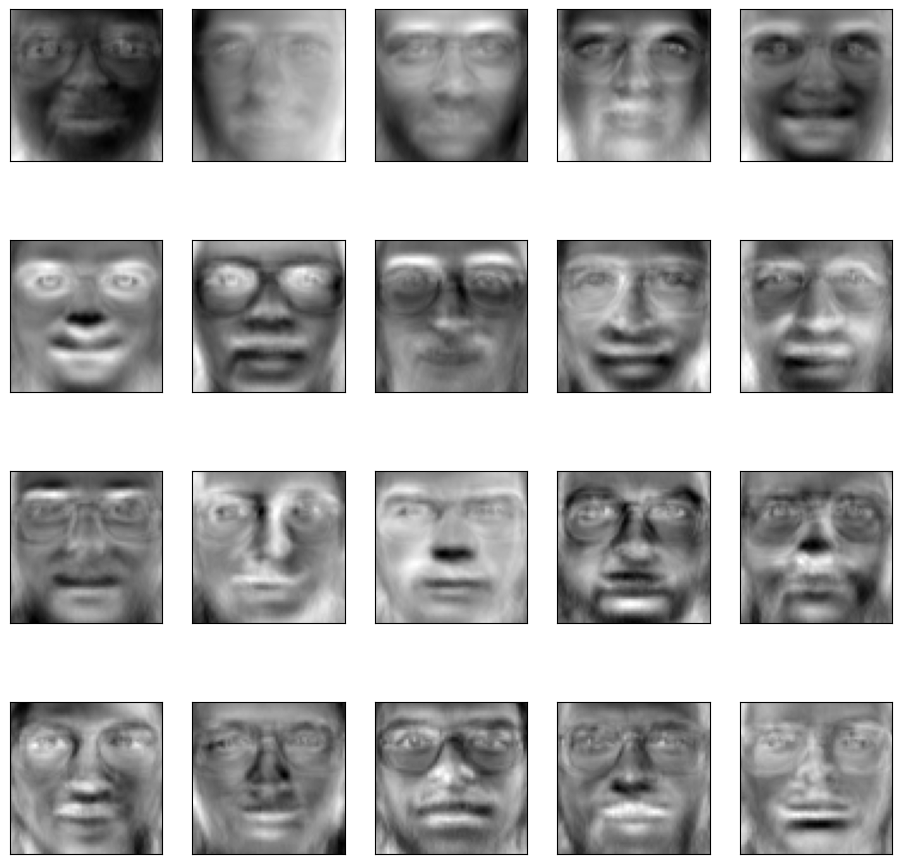

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets

# Load Olivetti faces dataset
x, _ = datasets.fetch_olivetti_faces(return_X_y=True)

# Standardize data by subtracting the mean
mean_face = np.mean(x, axis=0)
x_centered = x - mean_face

# Perform SVD
U, S, V = np.linalg.svd(x_centered, full_matrices=False)

# The right singular vectors (rows of V) are the eigenvectors of the covariance matrix
eigenfaces = V[:20, :]

# Function to plot images
def plot_images(data, h, w, n_row=4, n_col=5):
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        # Reshape each row (eigenface) to original image dimensions
        plt.imshow(data[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.xticks(())
        plt.yticks(())

# Plot the first 20 eigenfaces
plot_images(eigenfaces, 64, 64)
plt.show()



# YOUR CODE HERE <<<<<<<<<<<<<<

### 2.b) Picking the number of principal components (3 pts)
Plot the total amount variance explained versus the number of principal components.
Exactly how many principal components are needed to explain 95% of the variance in the data?

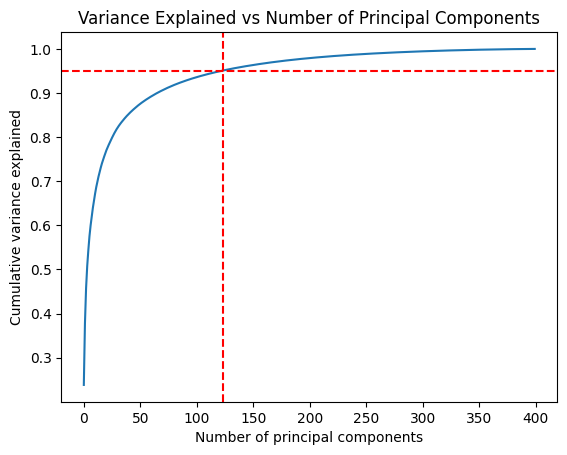

95% of the variance is explained using 123 principal components


In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets

# Load Olivetti faces dataset
x, _ = datasets.fetch_olivetti_faces(return_X_y=True)

# Standardize data by subtracting the mean
mean_face = np.mean(x, axis=0)
x_centered = x - mean_face

# Perform SVD
U, S, V = np.linalg.svd(x_centered, full_matrices=False)

# Calculate variance explained by each principal component
var_explained = np.square(S) / np.sum(np.square(S))

# Calculate cumulative variance explained
cumulative_var_explained = np.cumsum(var_explained)

# Find the number of components needed to explain 95% of variance
L = np.where(cumulative_var_explained >= 0.95)[0][0] + 1

# YOUR CODE HERE
plt.plot(cumulative_var_explained)
plt.xlabel("Number of principal components")
plt.ylabel("Cumulative variance explained")
plt.title("Variance Explained vs Number of Principal Components")
plt.axhline(y=0.95, color='r', linestyle='--')
plt.axvline(x=L, color='r', linestyle='--')
plt.show()

print(f'95% of the variance is explained using {L} principal components')


### 2.C) Classification using embeddings (2pts)
Use the `WeightedKNN` of previous question to do classification in the embedding space. Use 100 principal components, and optimize for the choice of K in the range $K \in \{1,\ldots,10\}$. 
This means instead of storing the entire data, we can store its compressed form as vectors of length 100, while maintaining the accuracy. Note that the portion of the code that performs hyper-parameter tuning is identical to what you have above.

In [10]:
def evaluate_model(k, x_train, y_train, x_val, y_val):
    model = WeightedKNN(K=k).fit(x_train, y_train)
    predictions = model.predict(x_val)
    accuracy = np.mean(np.argmax(predictions, axis=1) == y_val)
    return accuracy

# Optimize for K in the range {1, ..., 10}
best_k = None
best_accuracy = 0
for k in range(1, 11):
    acc = evaluate_model(k, x_train, y_train, x_val, y_val)
    if acc > best_accuracy:
        best_accuracy = acc
        best_k = k

print(f'The best K is {best_k} with a validation accuracy of {best_accuracy}')

The best K is 1 with a validation accuracy of 0.9125


## 3) K-Means clustering (7pts)
### 3a) Clustering faces (2pt)
Use the `KMeans` class from `scikit-learn` to cluster the data into K=40 clusters. Use other default values in the `scikit-learn` implementation. 
Plot the images for 5 out of 40 clusters. 

C:\Users\Buno\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


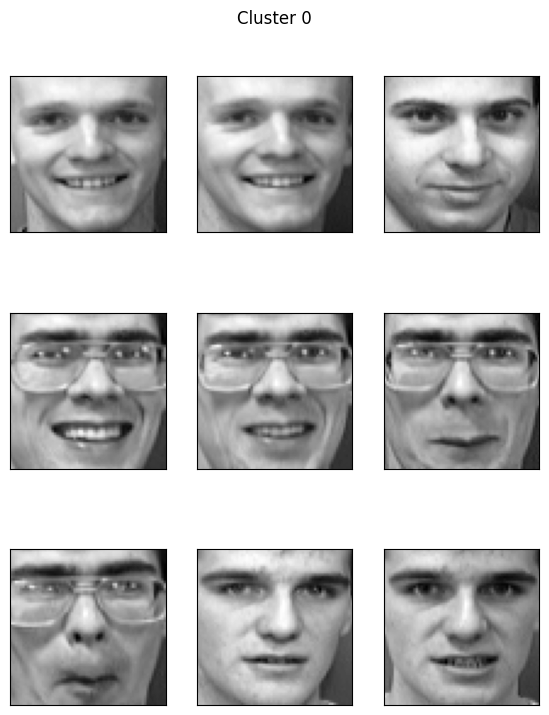

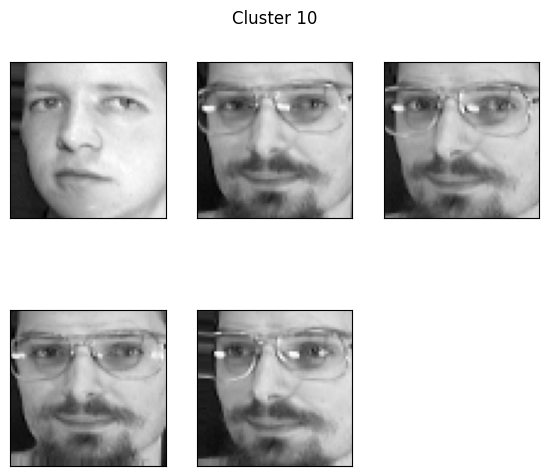

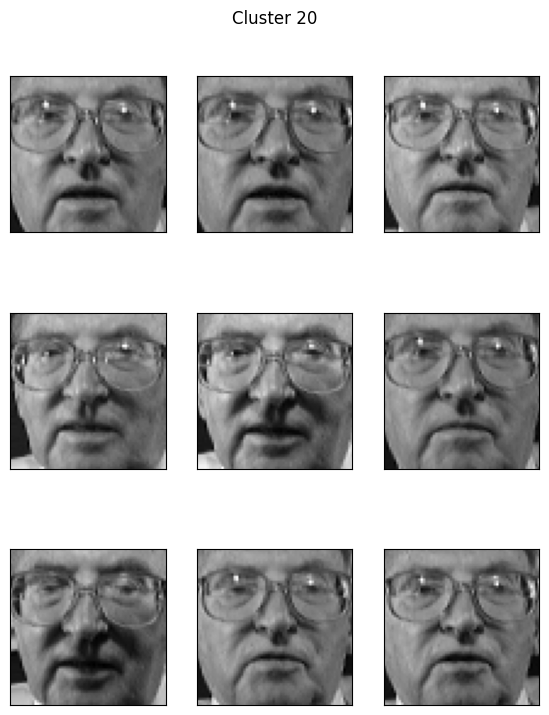

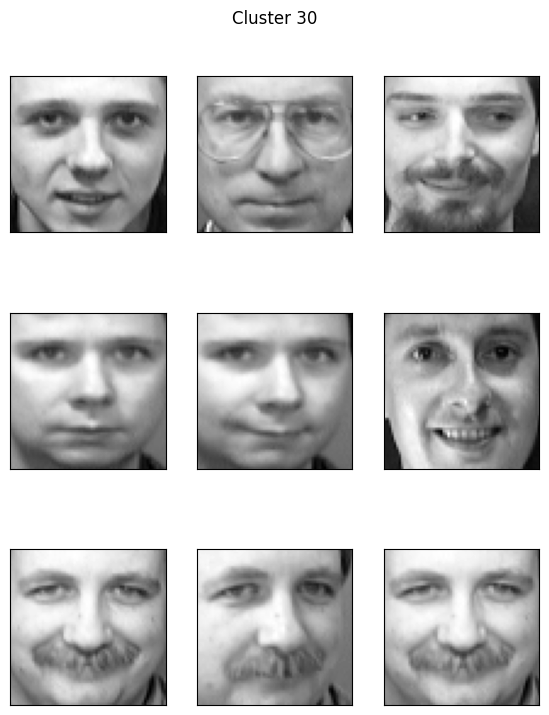

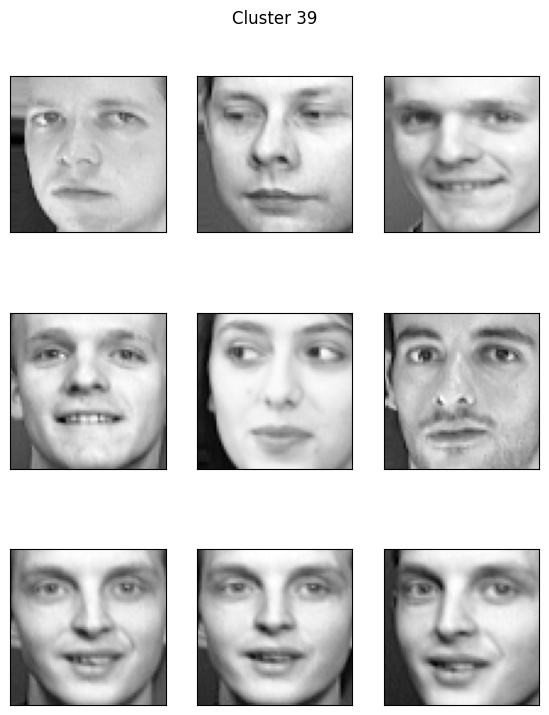

In [12]:
kmeans = KMeans(n_clusters=40, random_state=42).fit(x)
labels = kmeans.labels_

# Function to plot images
def plot_images(images, h, w, title=None):
    n_images = len(images)
    n_col = min(n_images, 3)  # Plot up to 3 images per row
    n_row = (n_images - 1) // n_col + 1  # Calculate the number of rows needed

    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_images):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.xticks(())
        plt.yticks(())
    if title is not None:
        plt.suptitle(title)

# Plot images from 5 clusters
selected_clusters = [0, 10, 20, 30, 39]  # Select any 5 cluster indices
for cluster_idx in selected_clusters:
    cluster_images = x[labels == cluster_idx]
    plot_images(cluster_images[:9], 64, 64, title=f'Cluster {cluster_idx}')  # Plot up to 9 images

plt.show()


### 3.b) Measuring clustering's agreement with true labels (5 pts)
You should see that clustering to some extend is able to identify class labels. However, they are not in complete agreement. Moreover, the order of clusters is completely arbitrary (i.e., cluster labels can be swapped with no change in the value of K-means objective). This means that two sets of labels are not directly comparable, and therefore a classification measure such as accuracy is not applicable.

Various *clustering agreement* measures exist that quantify the closeness of a clustering with a known ground truth. Two well-known measures are *Adjusted Rand Index (ARI)* and *Normalized Mutual Information (NMI)*. For this assignment we want to implement NMI to measure the agreement between different clustering techniques and the ground truth label in the face dataset above. Another motivation to implement NMI is because of its use of mutual information, and entropy. This would help familiarize you with practical implementation of these concepts.

If we assume that each clustering is giving a distribution over labels $p(Y), p'(Y')$, *mutual information* $\mathbb{I}(Y, Y') = \mathbb{D}_{KL}(p(Y,Y') \|| p(Y)p(Y'))$ between these distribution tells us how much one clustering tells us about the cluster labels produced by the alternative clustering. NMI then normalizes this value through division by the sum of entropies of $Y$ and $Y'$:
$$NMI(Y, Y') = \frac{2 \mathbb{I}(Y,Y')}{\mathbb{H}(Y) + \mathbb{H}(Y')}$$

Complete the implementation of NMI below. To test your implementation you can check against the impelementation of NMI in `scikit-learn`. A technical issue to have in mind is that when $p(Y=y) = 0$, $\log(p(y))$ evaluates to `Nan`. However, we know that, for example $p(y) \log p(y)$ should evaluate to zero in this case. To get around this problem we use `nansum` instead of `sum` when calculating quantities such as mutual information and entropy.
We can then compare the clustering to another clustering method, such as `spectral clustering` in terms of agreement with ground truth labels.

In [16]:
import numpy as np
from sklearn import datasets
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.metrics.cluster import normalized_mutual_info_score

# Load Olivetti faces dataset
x, y = datasets.fetch_olivetti_faces(return_X_y=True)

# Apply KMeans clustering
kmeans = KMeans(n_clusters=40, random_state=42)
y_cluster = kmeans.fit_predict(x)

# Apply Spectral clustering
spectral = SpectralClustering(n_clusters=40, random_state=42)
y_cluster_spec = spectral.fit_predict(x)

def entropy(p):
    return -np.nansum(p * np.log(p + 1e-10))

def mutual_information(p_joint, p_y, p_yp):
    # Using broadcasting to avoid explicit loops for better performance
    mi = np.nansum(p_joint * (np.log(p_joint + 1e-10) - np.log(p_y[:, None] + 1e-10) - np.log(p_yp[None, :] + 1e-10)))
    return mi

def nmi(y, yp):
    n = y.shape[0]
    c, cp = np.max(y) + 1, np.max(yp) + 1
    p_joint = np.zeros((c, cp))
    for i in range(n):
        p_joint[y[i], yp[i]] += 1
    p_joint /= n
    p_y, p_yp = np.sum(p_joint, axis=1), np.sum(p_joint, axis=0)
    mi = mutual_information(p_joint, p_y, p_yp)
    return 2 * mi / (entropy(p_y) + entropy(p_yp))

# Calculate NMI for K-means clustering
nmi_kmeans = nmi(y, y_cluster)
print(f'Agreement between K-means labels and ground truth labels is {nmi_kmeans}')

# Calculate NMI for Spectral clustering
nmi_spectral = nmi(y, y_cluster_spec)
print(f'Agreement between spectral clustering labels and ground truth labels is {nmi_spectral}')


C:\Users\Buno\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Agreement between K-means labels and ground truth labels is 0.7677656844189602
Agreement between spectral clustering labels and ground truth labels is 0.4827501855369494


C:\Users\Buno\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:1152: ConvergenceWarning: Number of distinct clusters (30) found smaller than n_clusters (40). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
